In [1]:
#imports
import numpy as np
import pandas as pd
import scipy.stats as stats

from acquire import wrangle_zillow
from prepare import prep_zillow
from prepare import remove_outliers
from prepare import tts_con

import matplotlib.pyplot as plt
import seaborn as sns

### Acquiring and preparing the data

In [2]:
#get data from SQL server
zillow=wrangle_zillow()

In [3]:
#raw data
zillow.head()

,bath_count,bed_count,property_value,finished_sq_ft,latitude,longitude
0,3.0,4.0,1609238.0,3551.0,34046607.0,-117862608.0
1,3.0,4.0,106406.0,2519.0,34221128.0,-118644081.0
2,2.0,3.0,369853.0,1285.0,33990681.0,-118115568.0
3,1.0,3.0,65848.0,1254.0,33847341.0,-118104378.0
4,2.0,3.0,89362.0,1988.0,33765269.0,-117848358.0


In [4]:
#checking info of raw data
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52358 entries, 0 to 52357
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bath_count      52358 non-null  float64
 1   bed_count       52358 non-null  float64
 2   property_value  52358 non-null  float64
 3   finished_sq_ft  52358 non-null  float64
 4   latitude        52358 non-null  float64
 5   longitude       52358 non-null  float64
dtypes: float64(6)
memory usage: 2.4 MB


In [5]:
#removing longitude and latitude
zillow=prep_zillow(zillow)
zillow.head()

,bath_count,bed_count,property_value,finished_sq_ft
0,3.0,4.0,1609238.0,3551.0
1,3.0,4.0,106406.0,2519.0
2,2.0,3.0,369853.0,1285.0
3,1.0,3.0,65848.0,1254.0
4,2.0,3.0,89362.0,1988.0


In [6]:
#removing the outliers and getting the fences
zillow, fences=remove_outliers(zillow)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46765 entries, 1 to 52357
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bath_count      46765 non-null  float64
 1   bed_count       46765 non-null  float64
 2   property_value  46765 non-null  float64
 3   finished_sq_ft  46765 non-null  float64
dtypes: float64(4)
memory usage: 1.8 MB


In [7]:
#fences for outliers
fences

,bath_count,bed_count,property_value,finished_sq_ft
upper_fence,4.5,5.5,1255866.75,3863.0
lower_fence,0.5,1.5,-443689.25,-289.0


### Splitting the data

In [8]:
train, val, test=tts_con(zillow)
train.size, val.size, test.size

(104752, 44896, 37412)

### Graphing each feature

In [9]:
#function to preview graphs for each feature
def feature_graphs():
    for col in train:
        print(col)
        ax = sns.histplot(x=col, data=train, kde=True)
        ax.lines[0].set_color('crimson')
        plt.show()

bath_count


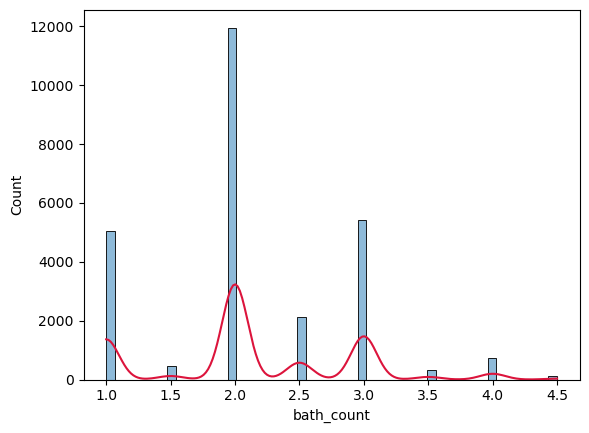

bed_count


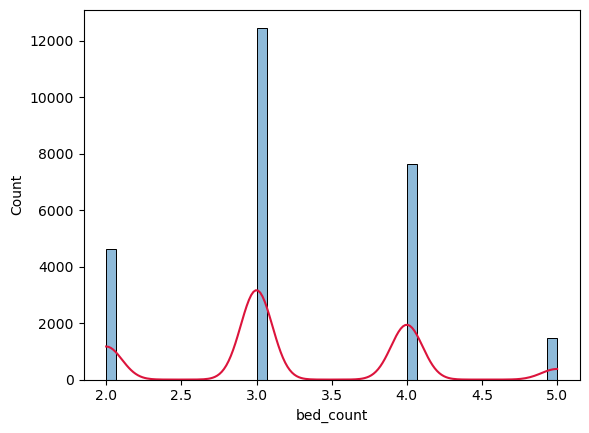

property_value


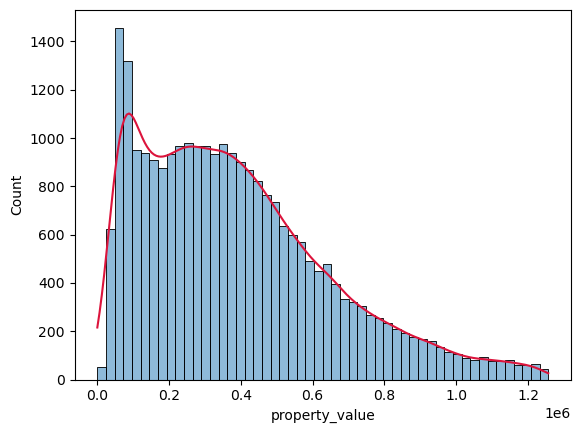

finished_sq_ft


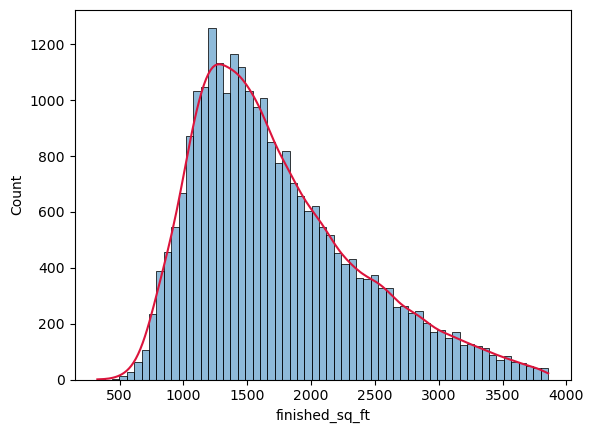

In [10]:
feature_graphs()

**Takeaways**  
* Finished square feet is almost a normal distribution.  
* Can invistigate 2 bath mean against total mean and 3 bedrooms mean against total mean.  
* Investigate bedrooms mean <3 and >3.  
* Corrlation between finished square feet and property value.


<div class="alert alert-info">
    <header>
    <h2>Exploration Question 1:</h2>
    </header>
    <dl>
        <dt>Is the property value of homes that have 2 bathrooms significantly lower than the mean of all homes?</dt>
        <dd>- $H_0$: There is no difference in between the property value of homes that have <strong>2 bathrooms</strong> the mean property value of all homes</dd>
        <dd>- $H_a$: The property value of homes with <strong>2 bathrooms</strong> is significantly lower than the mean of all homes</dd>
    </dl>
</div>

In [11]:
#subsetting the data into houses with only 2 bathrooms
train_2b= train[train['bath_count']==2]
train_2b.head()

,bath_count,bed_count,property_value,finished_sq_ft
32057,2.0,3.0,206678.0,1218.0
27554,2.0,4.0,542618.0,1638.0
45855,2.0,3.0,195294.0,1680.0
38063,2.0,4.0,107565.0,1300.0
29772,2.0,2.0,177501.0,1123.0


In [12]:
#plotting the subsample and all values
def eq1_graphs(): 
    plt.figure(figsize=(10,5))
    plt.subplot(221)
    sns.histplot(x='property_value', data=train_2b)
    plt.title('2 Bathroom Homes')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplot(222)
    sns.histplot(x='property_value', data=train)
    plt.title('All Homes')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplot(223)
    plt.title('2 Bathroom Homes and All Homes')
    sns.histplot(x='property_value', data=train_2b, alpha=.75, color='green', label= '2 Bathrooms')
    sns.histplot(x='property_value', data=train, alpha=.25, label='All Homes')
    plt.xlabel('Property Value')
    plt.axvline(x=(train['property_value'].mean()), color='red', label='Overall Mean')
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplots_adjust(left=0.1,
                        bottom=-0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

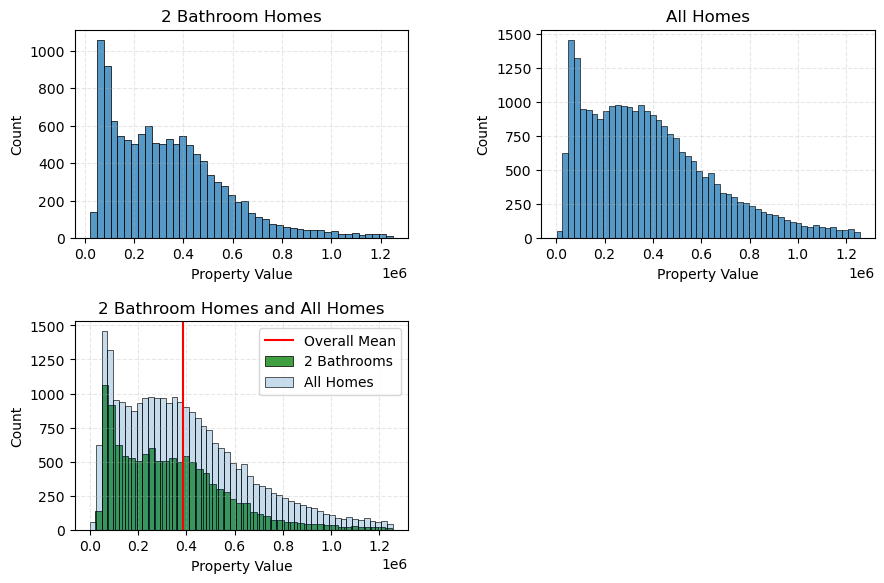

In [13]:
eq1_graphs()

In [14]:
#set alpha
alpha=.05

In [15]:
#running one sample t-test 
sample= train_2b['property_value']
overall_mean=train['property_value'].mean()

t, p = stats.ttest_1samp(sample, overall_mean, alternative='less')
print(t, p, alpha)

-24.24380507465109 4.3036527011951066e-127 0.05


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that property value of homes with 2 bathrooms is significantly lower than the average home in this dataset

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 2:</h2>
    </header>
    <dl>
        <dt>Is the property value of homes that have 3 bedrooms significantly lower than the mean of all homes?</dt>
        <dd>- $H_0$: There is no difference in between the property value of homes that have <strong>3 bedrooms</strong> the mean property value of all homes</dd>
        <dd>- $H_a$: The property value of homes with <strong>3 bedrooms</strong> is significantly lower than the mean of all homes</dd>
    </dl>
</div>

In [16]:
#Subsetting the data into homes that gave 3 bedrooms
train_3bed=train[train['bed_count']==3]
train_3bed.head()

,bath_count,bed_count,property_value,finished_sq_ft
32057,2.0,3.0,206678.0,1218.0
2083,1.5,3.0,582000.0,1294.0
45855,2.0,3.0,195294.0,1680.0
21711,3.0,3.0,395742.0,2471.0
24554,1.0,3.0,380733.0,1210.0


In [17]:
#plotting the subsample and all values
def eq2_graphs(): 
    plt.figure(figsize=(10,5))
    plt.subplot(221)
    sns.histplot(x='property_value', data=train_3bed)
    plt.title('3 Bedroom Homes')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplot(222)
    sns.histplot(x='property_value', data=train)
    plt.title('All Homes')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplot(223)
    plt.title('3 Bedroom Homes and All Homes')
    sns.histplot(x='property_value', data=train_3bed, alpha=.75, color='green', label= '3 Bedrooms')
    sns.histplot(x='property_value', data=train, alpha=.25, label='All Homes')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.axvline(x=(train['property_value'].mean()), color='red', label='Overall Mean')
    plt.legend()
    plt.subplots_adjust(left=0.1,
                        bottom=-0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

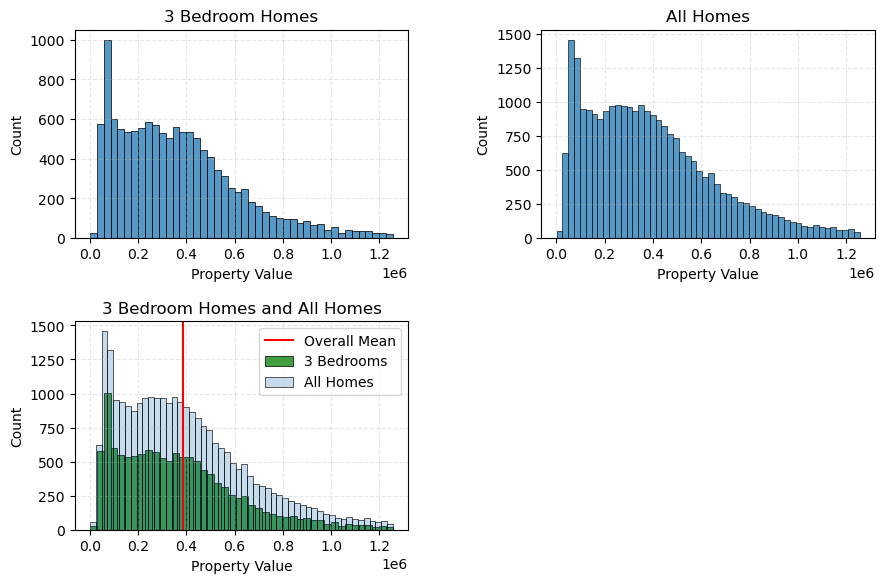

In [18]:
eq2_graphs()

In [19]:
#running one sample t-test 
sample2= train_3bed['property_value']
overall_mean=train['property_value'].mean()

t, p = stats.ttest_1samp(sample2, overall_mean, alternative='less')
print(t, p, alpha)

-10.951317264278622 4.382698658471545e-28 0.05


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that property value of homes with 3 bedrooms is significantly lower than the average home in this dataset

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 3:</h2>
    </header>
    <dl>
        <dt>Is the mean property value of homes that have less than 3.5 bedrooms significantly less than the mean of homes with greater than 3.5 bedrooms?</dt>
        <dd>- $H_0$: There is no difference in between the mean property value of homes that have <strong>less than 3.5</strong> bedrooms compared to the mean of homes with <strong>greater than 3.5</strong> bedrooms</dd>
        <dd>- $H_a$: The mean property value of homes that have <strong>less than 3.5</strong> bedrooms is significantly less compared to the mean of homes with <strong>greater than 3.5</strong> bedrooms</dd>
    </dl>
</div>

In [20]:
#subsetting the data
train_more3=train[train['bed_count']>3.5]
train_less3=train[train['bed_count']<3.5]

In [21]:
#plotting data
def eq3_graphs(): 
    plt.figure(figsize=(10,5))
    plt.subplot(221)
    sns.histplot(x='property_value', data=train_more3)
    plt.title('Homes With > 3.5 Bedrooms')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplot(222)
    sns.histplot(x='property_value', data=train_less3)
    plt.title('Homes With < 3.5 Bedrooms')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.subplot(223)
    plt.title('Homes With > 3.5 > Bedrooms')
    sns.histplot(x='property_value', data=train_more3, alpha=.75, color='green', label= 'Bedrooms > 3.5')
    sns.histplot(x='property_value', data=train_less3, alpha=.5, label='Bedrooms < 3.5')
    plt.xlabel('Property Value')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.axvline(x=(train_more3['property_value'].mean()), color='red', label='Bedrooms >3.5 Mean')
    plt.axvline(x=(train_less3['property_value'].mean()), color='yellow', label='Bedrooms <3.5 Mean')
    plt.legend()
    plt.subplots_adjust(left=0.1,
                        bottom=-0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

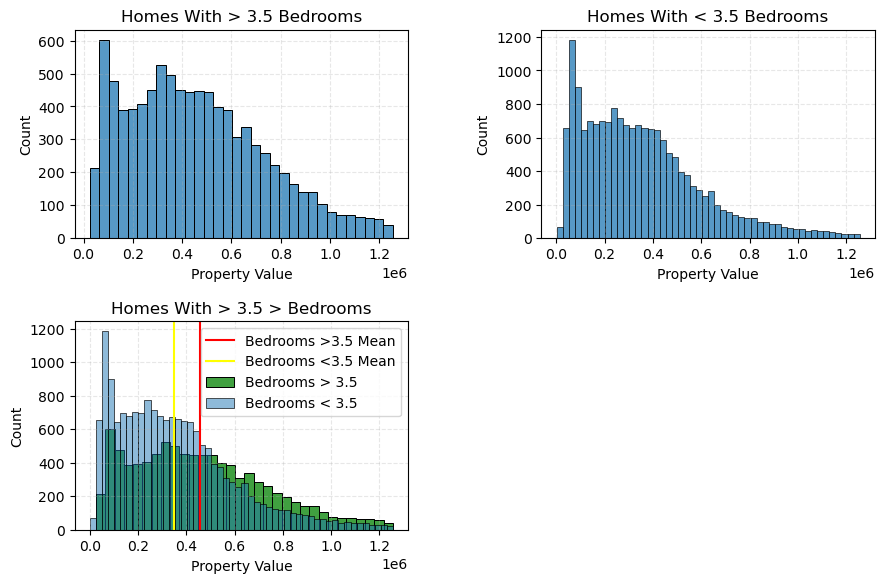

In [22]:
eq3_graphs()

In [23]:
#calculating variance
print(train_more3['property_value'].var())
print(train_less3['property_value'].var())

77008453855.60184
60139586016.19634


In [24]:
#running two sample t-test 
more3m= train_more3['property_value']
less3m=train_less3['property_value']

t, p = stats.ttest_ind(less3m, more3m, alternative='less', equal_var=False)
print(t, p, alpha)

-31.343397380223752 6.457898195742378e-210 0.05


### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that property value of homes with less than 3.5 (<=3) bedrooms is significantly lower than houses with greater than 3.5 (>3) bedrooms
    * This further builds on the second explore question that only looked at houses with 3 bedrooms

<div class="alert alert-info">
    <header>
    <h2>Exploration Question 4:</h2>
    </header>
    <dl>
        <dt>Is there a correlation between finished square feet and property value? If so, how strong?</dt>
        <dd>- $H_0$: There is <strong>no correlation</strong> between finished square feet and property value</dd>
        <dd>- $H_a$: There is a <strong>correlation</strong> between finished square feet and property value</dd>
    </dl>
</div>

In [26]:
#visualizing all correlations
correlations=train.corr()
correlations

,bath_count,bed_count,property_value,finished_sq_ft
bath_count,1.000000,0.590137,0.403174,0.788924
bed_count,0.590137,1.000000,0.212064,0.610271
property_value,0.403174,0.212064,1.000000,0.477693
finished_sq_ft,0.788924,0.610271,0.477693,1.000000


In [27]:
#correlation between property value and finished square feet
correlations.iloc[3,2]

0.4776931189198917

In [28]:
#correlation and p value another way
corr, p = stats.pearsonr(train['property_value'], train['finished_sq_ft'])
corr, p

(0.47769311891989136, 0.0)

### Takeaway
* The p value is lower than the alpha value
* We reject the null hypothesis:
    * We can say with confidence that there is a moderate correlation between the property value and finished square feet